In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'PEPE'
yf_crypto = 'PEPE24478'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2023-04-30,0.000000e+00,1.000000e-06,0.000000e+00,1.000000e-06,253721222
2023-05-01,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,522825244
2023-05-02,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,316033773
2023-05-03,1.000000e-06,1.000000e-06,1.000000e-06,1.000000e-06,245371458
2023-05-04,1.000000e-06,2.000000e-06,1.000000e-06,2.000000e-06,509285548


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-04,0.000014,0.000015,0.000014,0.000014,1270886811
2024-06-05,0.000014,0.000015,0.000014,0.000015,1434120193
2024-06-06,0.000015,0.000015,0.000014,0.000014,1070946562
2024-06-07,0.000014,0.000014,0.000012,0.000013,1949538461
2024-06-08,0.000013,0.000013,0.000012,0.000012,1225905124


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

1.2000000424450263e-05

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.993646,0.993735,0.990314,0.769208
High,0.993646,1.000000,0.991177,0.995870,0.809470
Low,0.993735,0.991177,1.000000,0.993284,0.762848
Close,0.990314,0.995870,0.993284,1.000000,0.799362
Volume,0.769208,0.809470,0.762848,0.799362,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2023-04-30,1.000000e-06,253721222
2023-05-01,1.000000e-06,522825244
2023-05-02,1.000000e-06,316033773
2023-05-03,1.000000e-06,245371458
2023-05-04,2.000000e-06,509285548
...,...,...
2024-06-04,1.400000e-05,1270886811
2024-06-05,1.500000e-05,1434120193
2024-06-06,1.400000e-05,1070946562


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate volatility
df_close_ma.loc[:, 'Percent Change'] = df_close_ma['Close'].pct_change()*100
df_close_ma.loc[:, 'Volatility'] = df_close_ma['Percent Change'].rolling(10).std(ddof=0) * np.sqrt(252)

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2023-06-18,1.000000e-06,82005737,1.000000e-06,0.000001,0.000001
2023-06-19,1.000000e-06,80774470,1.000000e-06,0.000001,0.000001
2023-06-20,1.000000e-06,134239390,1.000000e-06,0.000001,0.000001
2023-06-21,1.000000e-06,551611626,1.000000e-06,0.000001,0.000001
2023-06-22,2.000000e-06,842548593,1.100000e-06,0.000001,0.000002


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-06-04,0.000014,1270886811,0.000015,0.000012,0.000010
2024-06-05,0.000015,1434120193,0.000015,0.000012,0.000010
2024-06-06,0.000014,1070946562,0.000015,0.000012,0.000010
2024-06-07,0.000013,1949538461,0.000014,0.000013,0.000011
2024-06-08,0.000012,1225905124,0.000014,0.000013,0.000011


<Axes: xlabel='Date'>

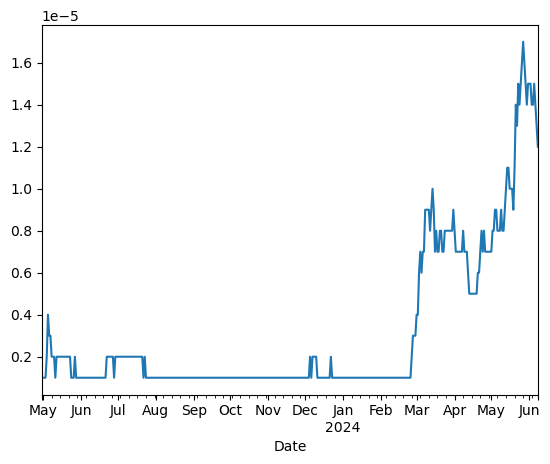

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [51]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

# Set cap
#df_close['cap'] = df_close['y'].max()

In [57]:
# Call the Prophet function, store as an object
crypto_model = Prophet()
#crypto_model = Prophet(growth='logistic')

In [58]:
# Fit the time-series model.
crypto_model.fit(df_close)

22:56:57 - cmdstanpy - INFO - Chain [1] start processing
22:56:57 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
491,2024-09-02
492,2024-09-03
493,2024-09-04
494,2024-09-05
495,2024-09-06


In [60]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
466,2024-08-08,0.000019,0.000017,0.000021,0.000018,0.000019,3.323944e-08,3.323944e-08,3.323944e-08,3.323944e-08,3.323944e-08,3.323944e-08,0.0,0.0,0.0,0.000019
467,2024-08-09,0.000019,0.000017,0.000021,0.000018,0.000019,2.274956e-08,2.274956e-08,2.274956e-08,2.274956e-08,2.274956e-08,2.274956e-08,0.0,0.0,0.0,0.000019
468,2024-08-10,0.000019,0.000017,0.000021,0.000019,0.000019,-5.862959e-08,-5.862959e-08,-5.862959e-08,-5.862959e-08,-5.862959e-08,-5.862959e-08,0.0,0.0,0.0,0.000019
469,2024-08-11,0.000019,0.000018,0.000021,0.000019,0.000020,1.968485e-08,1.968485e-08,1.968485e-08,1.968485e-08,1.968485e-08,1.968485e-08,0.0,0.0,0.0,0.000019
470,2024-08-12,0.000019,0.000018,0.000021,0.000019,0.000020,9.941835e-09,9.941835e-09,9.941835e-09,9.941835e-09,9.941835e-09,9.941835e-09,0.0,0.0,0.0,0.000019
471,2024-08-13,0.000019,0.000018,0.000021,0.000019,0.000020,1.781907e-08,1.781907e-08,1.781907e-08,1.781907e-08,1.781907e-08,1.781907e-08,0.0,0.0,0.0,0.000019
472,2024-08-14,0.000019,0.000018,0.000021,0.000019,0.000020,-4.480517e-08,-4.480517e-08,-4.480517e-08,-4.480517e-08,-4.480517e-08,-4.480517e-08,0.0,0.0,0.0,0.000019
473,2024-08-15,0.000019,0.000018,0.000021,0.000019,0.000020,3.323944e-08,3.323944e-08,3.323944e-08,3.323944e-08,3.323944e-08,3.323944e-08,0.0,0.0,0.0,0.000020
474,2024-08-16,0.000020,0.000018,0.000021,0.000019,0.000020,2.274956e-08,2.274956e-08,2.274956e-08,2.274956e-08,2.274956e-08,2.274956e-08,0.0,0.0,0.0,0.000020
475,2024-08-17,0.000020,0.000018,0.000021,0.000019,0.000020,-5.862959e-08,-5.862959e-08,-5.862959e-08,-5.862959e-08,-5.862959e-08,-5.862959e-08,0.0,0.0,0.0,0.000020


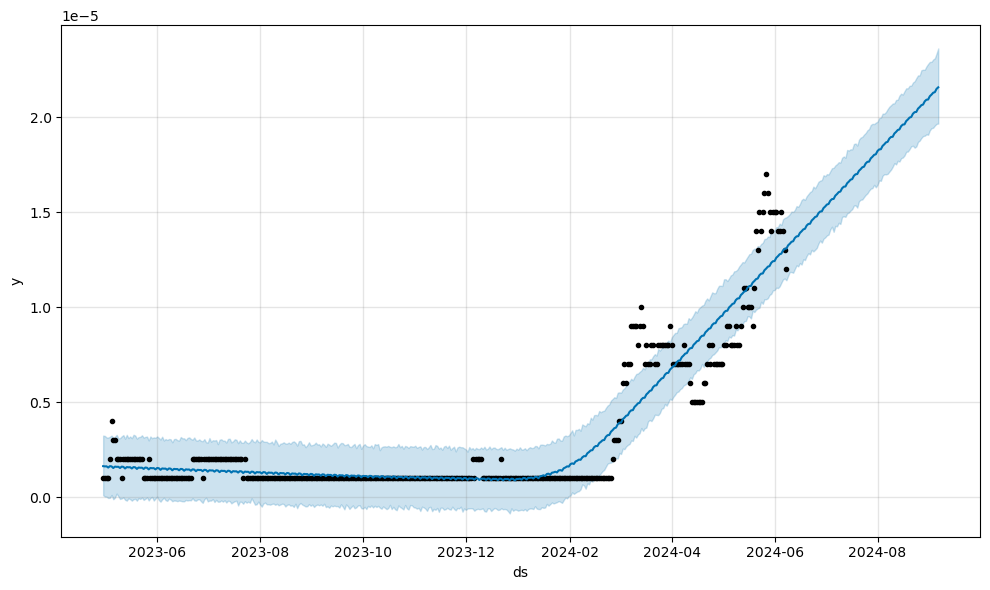

In [61]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [62]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [63]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,0.000013,0.000012,0.000015
2024-06-10,0.000013,0.000012,0.000015
2024-06-11,0.000013,0.000012,0.000015
2024-06-12,0.000013,0.000012,0.000015
2024-06-13,0.000014,0.000012,0.000015
...,...,...,...
2024-09-02,0.000021,0.000019,0.000023
2024-09-03,0.000021,0.000019,0.000023
2024-09-04,0.000021,0.000020,0.000023


In [64]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

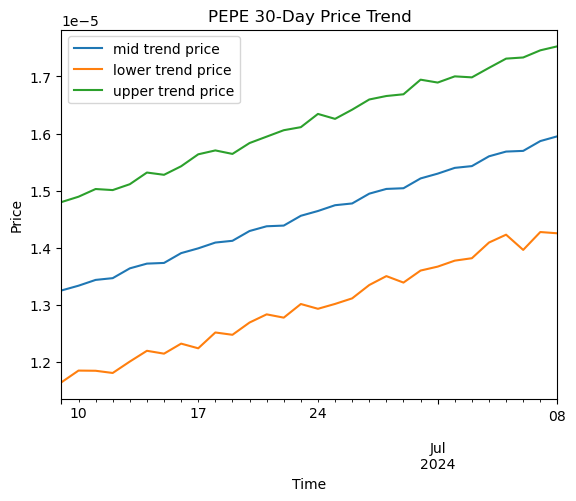

In [65]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

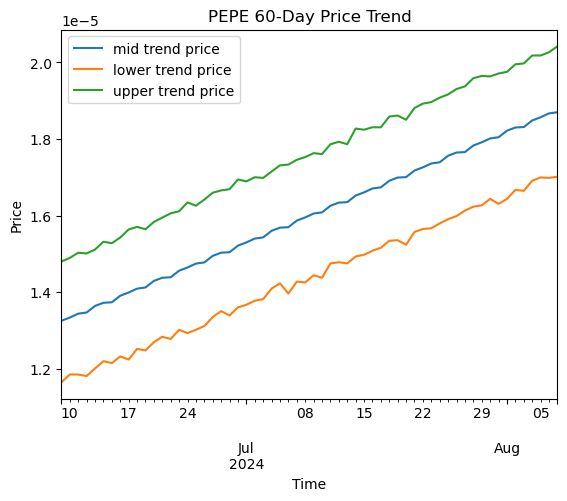

In [66]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

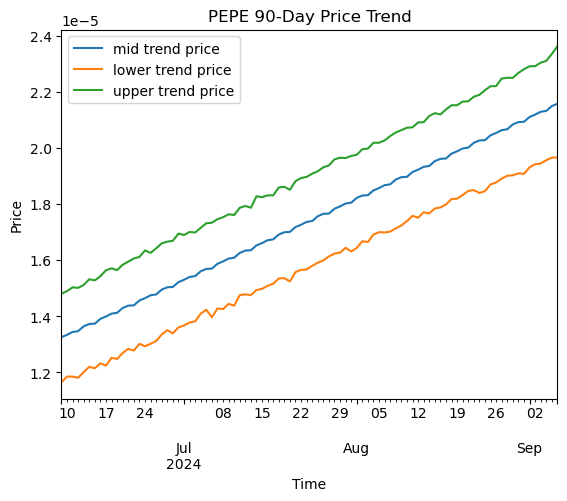

In [67]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [68]:
# Retrieve last closing price
last_close_price

1.2000000424450263e-05

In [69]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

1.3252196583780266e-05

In [70]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

1.2626098504115266e-05

In [71]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

1.3240114834319236e-05

In [72]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

1.6046252308121653e-05

In [73]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

1.885867023546758e-05

In [74]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

2.1598864766902183e-05

In [75]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

0.271

In [76]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

0.494

In [77]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.711

In [78]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

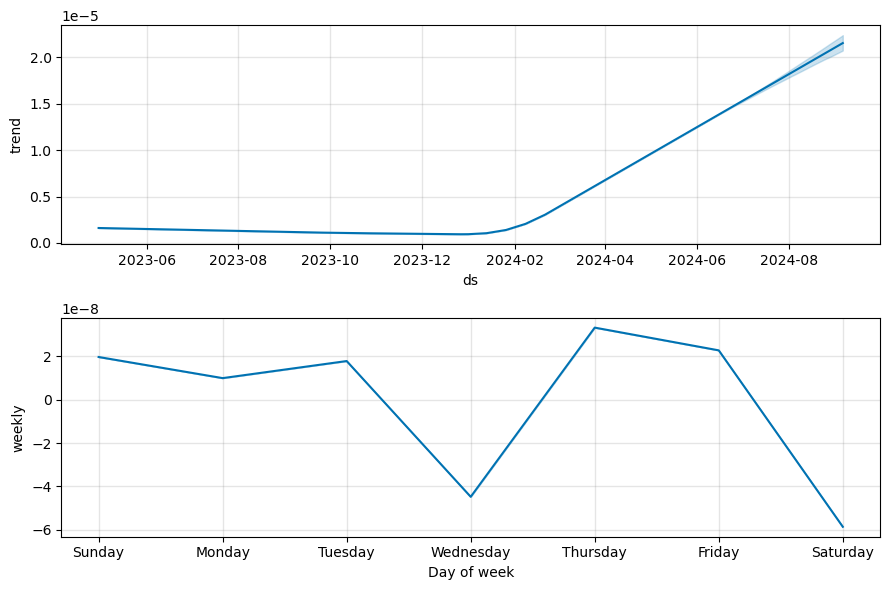

In [79]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

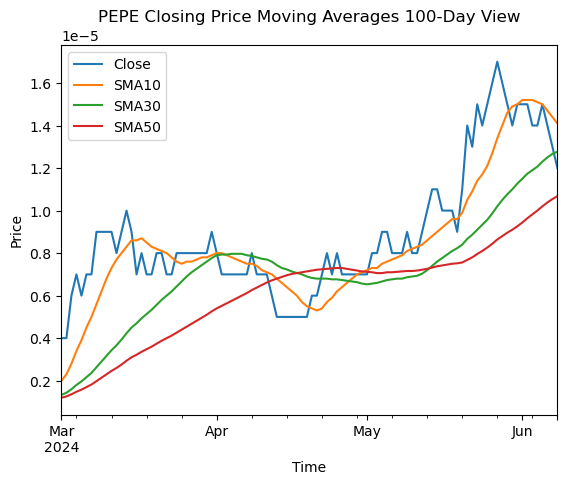

In [80]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

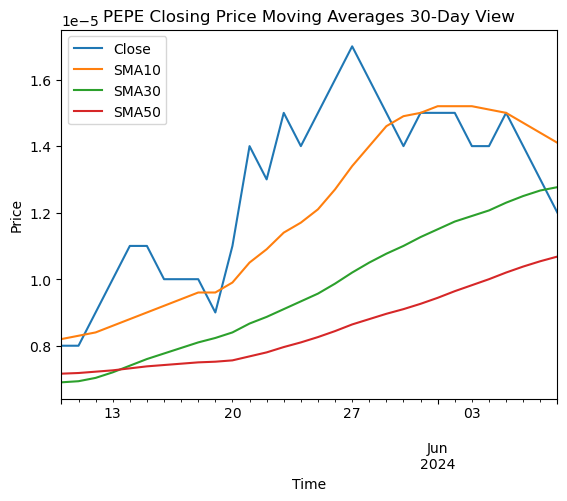

In [81]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')    
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [82]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [83]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [84]:
f = open(f'{file_name}', "r")
print(f.read())

PEPE,1.2000000424450263e-05,0.2708797023000926,0.49362609750913267,0.7106523254085491

